In [4]:
import pandas as pd
import sklearn
import numpy as np
import nltk
import re
import pickle
import config as cfg
import collections
import matplotlib.pyplot as plt
from manage_docs import *
from tqdm import tqdm
from wordcloud import WordCloud
import seaborn as sns
sns.set_style('whitegrid')



from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

from sklearn import tree
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_selection import chi2

from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline

from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_fscore_support
from sklearn.decomposition import LatentDirichletAllocation as LDA

In [5]:
print("Loading in Files....")
infile = open('papers2.p','rb')
papers = pickle.load(infile)
infile.close()

print("Getting Papers without References....")
split_papers = get_papers_without_references(papers)



Loading in Files....
Getting Papers without References....
0 / 19861
100 / 19861
200 / 19861
300 / 19861
400 / 19861
500 / 19861
600 / 19861
700 / 19861
800 / 19861
900 / 19861
1000 / 19861
1100 / 19861
1200 / 19861
1300 / 19861
1400 / 19861
1500 / 19861
1600 / 19861
1700 / 19861
1800 / 19861
1900 / 19861
2000 / 19861
2100 / 19861
2200 / 19861
2300 / 19861
2400 / 19861
2500 / 19861
2600 / 19861
2700 / 19861
2800 / 19861
2900 / 19861
3000 / 19861
3100 / 19861
3200 / 19861
3300 / 19861
3400 / 19861
3500 / 19861
3600 / 19861
3700 / 19861
3800 / 19861
3900 / 19861
4000 / 19861
4100 / 19861
4200 / 19861
4300 / 19861
4400 / 19861
4500 / 19861
4600 / 19861
4700 / 19861
4800 / 19861
4900 / 19861
5000 / 19861
5100 / 19861
5200 / 19861
5300 / 19861
5400 / 19861
5500 / 19861
5600 / 19861
5700 / 19861
5800 / 19861
5900 / 19861
6000 / 19861
6100 / 19861
6200 / 19861
6300 / 19861
6400 / 19861
6500 / 19861
6600 / 19861
6700 / 19861
6800 / 19861
6900 / 19861
7000 / 19861
7100 / 19861
7200 / 19861
7300

In [6]:
# create large df of papers
papers_df = pd.DataFrame.from_records(p.to_dict() for p in split_papers)

In [10]:
# papers head
cv_df = papers_df.loc[papers_df['conference'] == 'CVPR']
cv_df.head()
# papers_df.head()

,unique_id,year,title,pdf_url,authors,paper_text,abstract,conference
5280,5808663,2019,Finding Task-Relevant Features for Few-Shot Le...,http://openaccess.thecvf.com/content_CVPR_2019...,"[ Hongyang Li, David Eigen, Samuel Dodge, M...",Finding Task-Relevant Features for Few-Shot Le...,\nFew-shot learning is an important area of re...,CVPR
5281,11617326,2019,Edge-Labeling Graph Neural Network for Few-Sho...,http://openaccess.thecvf.com/content_CVPR_2019...,"[ Jongmin Kim, Taesup Kim, Sungwoong Kim, C...",Edge-Labeling Graph Neural Network for Few-sho...,"\nIn this paper, we propose a novel edge-label...",CVPR
5282,17425989,2019,Generating Classification Weights With GNN Den...,http://openaccess.thecvf.com/content_CVPR_2019...,"[ Spyros Gidaris, Nikos Komodakis]",Generating Classiﬁcation Weights with GNN Deno...,\nGiven an initial recognition model already t...,CVPR
5283,23234652,2019,Kervolutional Neural Networks,http://openaccess.thecvf.com/content_CVPR_2019...,"[ Chen Wang, Jianfei Yang, Lihua Xie, Junso...",Kervolutional Neural Networks Chen Wang1 Jia...,\nConvolutional neural networks (CNNs) have en...,CVPR
5284,29043315,2019,Why ReLU Networks Yield High-Confidence Predic...,http://openaccess.thecvf.com/content_CVPR_2019...,"[ Matthias Hein, Maksym Andriushchenko, Juli...",Why ReLU networks yield high-conﬁdence predict...,"\nClassifiers used in the wild, in particular ...",CVPR


In [5]:
# Remove the columns
papers_df = papers_df.drop(columns=['unique_id', 'pdf_url'], axis=1)
# Print out the first rows of papers
papers_df.head()

,year,title,authors,paper_text,abstract,conference
0,2017,SnapNETS: Automatic Segmentation of Network Se...,"Sorour E. Amiri, Liangzhe Chen, B. Aditya Prakash",Proceedings of the Thirty-First AAAI Conferenc...,Given a sequence of snapshots of flu propagati...,aaai
1,2017,Taming the Matthew Effect in Online Markets wi...,"Franco Berbeglia, Pascal Van Hentenryck",Proceedings of the Thirty-First AAAI Conferenc...,Social influence has been shown to create a Ma...,aaai
2,2017,A Leukocyte Detection Technique in Blood Smear...,"Deblina Bhattacharjee, Anand Paul",Proceedings of the Thirty-First AAAI Conferenc...,"For quite some time, the analysis of leukocyte...",aaai
3,2017,Partitioned Sampling of Public Opinions Based ...,"Weiran Huang, Liang Li, Wei Chen",Proceedings of the Thirty-First AAAI Conferenc...,Public opinion polling is usually done by rand...,aaai
4,2017,Novel Geometric Approach for Global Alignment ...,"Yangwei Liu, Hu Ding, Danyang Chen, Jinhui Xu",Proceedings of the Thirty-First AAAI Conferenc...,In this paper we present a novel geometric met...,aaai


In [6]:
# process text by removing punctuation and lower case
papers_df['paper_text_processed'] = papers_df['paper_text'].map(lambda x: re.sub('[,\.!?]', '', x))
papers_df['paper_text_processed'] = papers_df['paper_text_processed'].map(lambda x: x.lower())

# process abstract
papers_df['paper_abstract_processed'] = papers_df['abstract'].map(lambda x: re.sub('[,\.!?]', '', x))
papers_df['paper_abstract_processed'] = papers_df['paper_abstract_processed'].map(lambda x: x.lower())

# process titles
papers_df['paper_title_processed'] = papers_df['title'].map(lambda x: re.sub('[,\.!?]', '', x))
papers_df['paper_title_processed'] = papers_df['paper_title_processed'].map(lambda x: x.lower())

# Print out the first rows of papers
print("Titles Processed: ")
display(papers_df['paper_title_processed'].head())

print("Text Processed: ")
display(papers_df['paper_text_processed'].head())

print("Text Processed: ")
display(papers_df['paper_abstract_processed'].head())

Titles Processed: 


0    snapnets: automatic segmentation of network se...
1    taming the matthew effect in online markets wi...
2    a leukocyte detection technique in blood smear...
3    partitioned sampling of public opinions based ...
4    novel geometric approach for global alignment ...
Name: paper_title_processed, dtype: object

Text Processed: 


0    proceedings of the thirty-first aaai conferenc...
1    proceedings of the thirty-first aaai conferenc...
2    proceedings of the thirty-first aaai conferenc...
3    proceedings of the thirty-first aaai conferenc...
4    proceedings of the thirty-first aaai conferenc...
Name: paper_text_processed, dtype: object

Text Processed: 


0    given a sequence of snapshots of flu propagati...
1    social influence has been shown to create a ma...
2    for quite some time the analysis of leukocyte ...
3    public opinion polling is usually done by rand...
4    in this paper we present a novel geometric met...
Name: paper_abstract_processed, dtype: object

In [7]:
len(papers_df['paper_abstract_processed'].values[:5000])

5000

In [8]:
# Join the different processed titles together.
# long_string = ','.join(list(papers_df['paper_text_processed'].values))
# test_string = ','.join(list(papers_df['paper_text_processed'].values[:2000]))
# title_long = ','.join(list(papers_df['paper_title_processed'].values))
train_abstract = ','.join(list(papers_df['paper_abstract_processed'].values))

In [9]:
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')

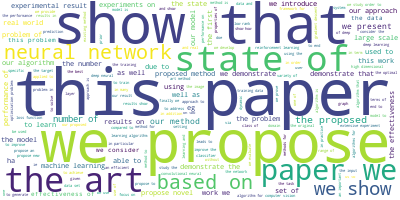

In [10]:
# Generate a word cloud for titles
wordcloud.generate(train_abstract)

# Visualize the word cloud
wordcloud.to_image()

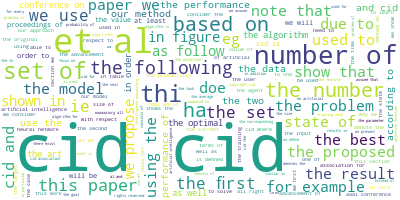

In [14]:
# # Generate a word cloud for test string
# wordcloud.generate(test_string)

# # Visualize the word cloud
# wordcloud.to_image()

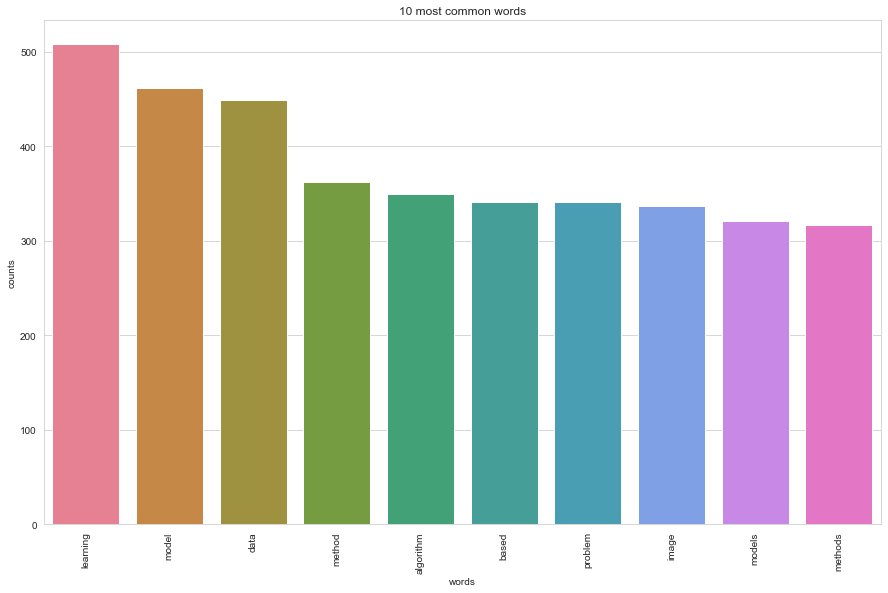

In [11]:
def plot_10_most_common_words(data, vectorizer):
    words = vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()
    
count_vectorizer = CountVectorizer(stop_words='english')
tfidf_vectorizer = TfidfVectorizer(stop_words='english')


# # text
# count_data = count_vectorizer.fit_transform(papers_df['paper_text_processed'][:2000])
# plot_10_most_common_words(count_data, count_vectorizer)

# title
title_data = tfidf_vectorizer.fit_transform(papers_df['paper_abstract_processed'])
plot_10_most_common_words(title_data, tfidf_vectorizer)

In [13]:
def print_topics(model, vectorizer, n_top_words):
    words = vectorizer.get_feature_names()
    for topic, comp in enumerate(model.components_):
        word_idx = np.argsort(comp)[::-1][:n_top_words]

        # store the words most relevant to the topic
        for i in word_idx:
            topic_words[topic] = [words[i] for i in word_idx]
    
    for topic, words in topic_words.items():
        print('Topic: %d' % topic)
        print('  %s' % ', '.join(words))
    
topic_words = {}       
number_topics = 10
number_words = 10

lda = LDA(n_components=number_topics)
lda.fit_transform(title_data)

print("Topics found via LDA:")
print_topics(lda, tfidf_vectorizer, number_words)

Topics found via LDA:
Topic: 0
  360, salience, kidney, patients, federated, patient, disaggregation, representatives, tts, monolingual
Topic: 1
  crm, ic, gtd, suffix, ns, vendors, mh, fpt, dca, gait
Topic: 2
  learning, algorithm, data, problem, algorithms, model, method, problems, optimization, based
Topic: 3
  image, model, network, learning, images, object, data, method, based, 3d
Topic: 4
  shadow, hypergraphs, multilinear, equivariance, cad, nlos, ldr, kappa, mvs, htl
Topic: 5
  tournament, spd, puzzles, bfgs, hrl, passages, psgd, subcategories, superposition, maxent
Topic: 6
  auction, bidders, marl, students, sc, cake, ed, ss, violation, hogwild
Topic: 7
  sdca, sg, gait, barycenter, sgld, lrr, epistemic, outer, mapf, sinkhorn
Topic: 8
  au, roi, hsi, dml, mot, bcd, pml, objectness, aus, session
Topic: 9
  da, shutter, mc, bc, miml, pds, stragglers, reaction, gac, automl
